In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
import pandas as pd
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
def init_weights_test(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [17]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStatsCB(append_stats,fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
cbs_get_preds = [DeviceCB(), metrics, astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights_test, leaky=0.1)
iwm = partial(init_weights_test, leaky=0.0003)

In [18]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

In [19]:
GeneralRelu?

Init signature: GeneralRelu(leak=None, sub=None, maxv=None)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
         

In [55]:
class TopLossesCallback(Callback):
    
    def __init__(self):
        self.epoch_preds = []
        self.epoch_targets = []
        self.epoch_losses = []
    
    @torch.no_grad()
    def _calculate_top_losses(self):
        preds = torch.cat(self.epoch_preds, dim=0)
        targets = torch.cat(self.epoch_targets, dim=0)
        losses = F.cross_entropy(preds, targets, reduce=False)
        return torch.topk(losses, preds.shape[0]).indices

    def after_batch(self, learn):
        if learn.model.training:
            return
        self.epoch_preds.append(to_cpu(learn.preds))
        self.epoch_targets.append(to_cpu(learn.batch[1]))
        self.epoch_losses.append(to_cpu(learn.loss))

    def before_epoch(self, learn):
        self.epoch_preds = []
        self.epoch_targets = []
        self.epoch_losses = []        

    def after_epoch(self, learn):
        if learn.model.training:
            return
        learn.top_loss_preds = torch.cat(self.epoch_preds)
        learn.top_loss_targets = torch.cat(self.epoch_preds)
        learn.top_loss_losses = torch.tensor(self.epoch_losses)

In [21]:
p1=torch.tensor([1,2,3,4])
p2=torch.tensor([5,6,7,8])
ml = [p1, p2]


In [22]:
class MishActivation(nn.Module):
    def __init__(self, sub=None, maxv=None):
        super().__init__()
        self.sub, self. maxv = sub, maxv
        
    def forward(self, x):
        x = torch.tanh(F.softplus(x))
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x = x.clamp_max_(self.maxv)
        return x

In [23]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [27]:
## Case1: Base model with Leaky Relu 

In [24]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=[0.0, 0.0]):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop[0])]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Dropout1d(drop[1]), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [28]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.1]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.598,1.286,0,train
0.738,0.899,0,eval
0.727,0.898,1,train
0.810,0.588,1,eval
0.763,0.749,2,train
0.852,0.505,2,eval
0.774,0.670,3,train
0.842,0.458,3,eval
0.794,0.589,4,train
0.885,0.344,4,eval


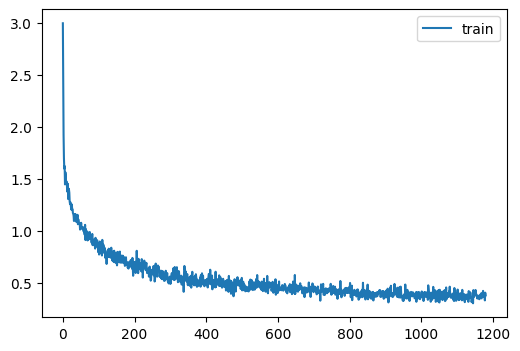

In [29]:
learn.fit(epochs)

In [30]:
model_summary={}
model_summary['case_01'] = {
    'act_func': 'GRLU(def)',
    'model': 'base',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.1',
    'seed': 42,
    '5_ep_loss': 0.355,
    '5_ep_acc': 88.5,
    '20_ep_loss': 0.174,
    '20_ep_acc': 94.1,
}

In [31]:
model_summary

{'case_01': {'act_func': 'GRLU(def)',
  'model': 'base',
  'lr_max': 0.01,
  'drops': '0.1, 0.1',
  'seed': 42,
  '5_ep_loss': 0.355,
  '5_ep_acc': 88.5,
  '20_ep_loss': 0.174,
  '20_ep_acc': 94.1}}

## Case2: Base model, change activation to Mish 

In [32]:
act_mish = partial(MishActivation, sub=None, maxv=None)

In [33]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_mish, norm=nn.BatchNorm2d, drop=[0.1, 0.1]).apply(iwm)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.443,1.715,0,train
0.490,1.518,0,eval
0.621,1.218,1,train
0.588,1.174,1,eval
0.692,0.955,2,train
0.747,0.819,2,eval
0.709,0.865,3,train
0.703,0.967,3,eval
0.739,0.748,4,train
0.774,0.645,4,eval


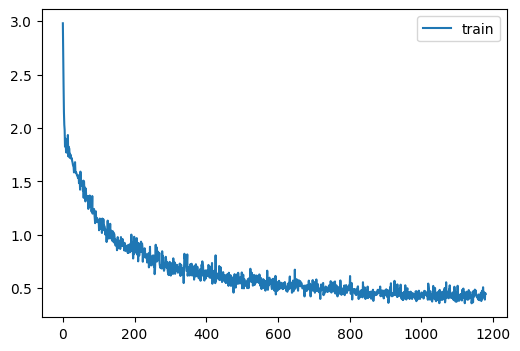

In [34]:
learn.fit(20)

In [35]:
model_summary['case_02'] = {
    'act_func': 'Mish(def)',
    'model': 'base',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.1',
    'seed': 42,
    '5_ep_loss': 0.645,
    '5_ep_acc': 77.4,
    '20_ep_loss': 0.215,
    '20_ep_acc': 92.4,
}

## Case3: Base Model, No Initial dropout

In [36]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=[0.0, 0.1]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.639,1.197,0,train
0.796,0.749,0,eval
0.751,0.838,1,train
0.845,0.538,1,eval
0.781,0.707,2,train
0.823,0.581,2,eval
0.779,0.660,3,train
0.835,0.485,3,eval
0.796,0.584,4,train
0.890,0.353,4,eval


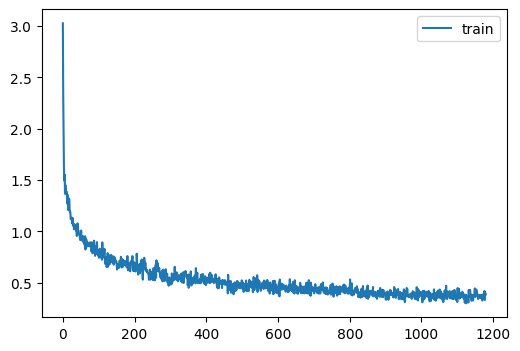

In [37]:
learn.fit(epochs)

In [38]:
model_summary['case_03'] = {
    'act_func': 'GRLU(def)',
    'model': 'base',
    'lr_max': 1.E-2,
    'drops': '0.0, 0.1',
    'seed': 42,
    '5_ep_loss': 0.353,
    '5_ep_acc': 89.0,
    '20_ep_loss': 0.178,
    '20_ep_acc': 94.0,
}

## Case 4: Base model with no final dropout

In [39]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.656,1.184,0,train
0.757,0.853,0,eval
0.799,0.760,1,train
0.807,0.588,1,eval
0.839,0.591,2,train
0.842,0.517,2,eval
0.851,0.498,3,train
0.788,0.642,3,eval
0.872,0.399,4,train
0.878,0.366,4,eval


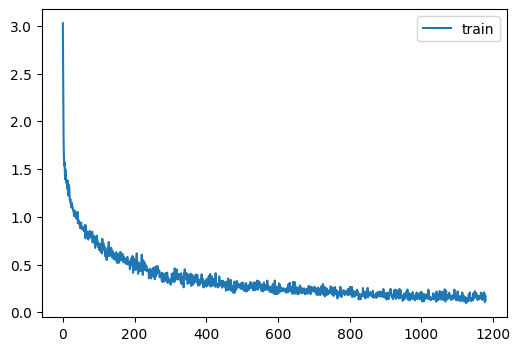

In [40]:
learn.fit(epochs)

In [41]:
model_summary['case_04'] = {
    'act_func': 'GRLU(def)',
    'model': 'base',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.0',
    'seed': 42,
    '5_ep_loss': 0.366,
    '5_ep_acc': 87.8,
    '20_ep_loss': 0.172,
    '20_ep_acc': 0.940,
}

## Case 5: Increasing dropout in first layer

In [42]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=[0.2, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.624,1.257,0,train
0.695,0.950,0,eval
0.784,0.792,1,train
0.797,0.591,1,eval
0.829,0.615,2,train
0.817,0.565,2,eval
0.848,0.509,3,train
0.850,0.449,3,eval
0.867,0.414,4,train
0.842,0.452,4,eval


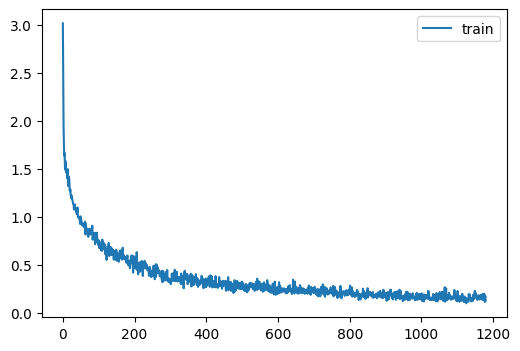

In [43]:
learn.fit(epochs)

In [45]:
model_summary['case_05'] = {
    'act_func': 'GRLU(def)',
    'model': 'base',
    'lr_max': 1.E-2,
    'drops': '0.2, 0.0',
    'seed': 42,
    '5_ep_loss': 0.452,
    '5_ep_acc': 84.2,
    '20_ep_loss': 0.176,
    '20_ep_acc': 0.938,
}

## Case 6: Add dropout after last conv layer

In [12]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=[0.0, 0.0, 0.0]):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop[0])]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]    
    layers += [nn.Dropout2d(drop[1]), nn.Flatten(), nn.Dropout1d(drop[1]), nn.Linear(nfs[-1], 10, bias=False), 
                            nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [39]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model2(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.1, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.587,1.304,0,True
0.766,0.798,0,False
0.729,0.892,1,True
0.838,0.578,1,False
0.764,0.744,2,True
0.853,0.460,2,False
0.775,0.667,3,True
0.866,0.410,3,False
0.793,0.592,4,True
0.878,0.361,4,False


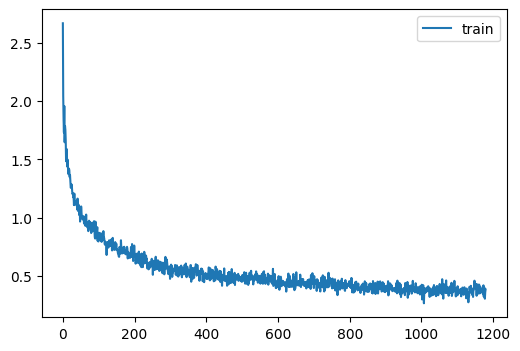

In [40]:
learn.fit(epochs)

In [43]:
model_summary['case_06'] = {
    'act_func': 'GRLU(def)',
    'model': 'model2',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.1, 0.0',
    'seed': 42,
    '5_ep_loss': 0.361,
    '5_ep_acc': 87.8,
    '20_ep_loss': 0.173,
    '20_ep_acc': 0.939,
}

## Model Architecture

## Case7 

In [47]:
def _conv_block2(ni, nf, stride, ks=3, act=act_gr, norm=None):
    """ Note that the architectual choice being made here is that the second conv does the re-scaling
    by keeping the number of channels the same but reduces the resolution by using stride=2
    
    The pass through block uses a pooling layer to reduce the resolution and then a basic conv to change
    the number of channels to that required
    
    """
    return nn.Sequential(
        conv(ni, nf, stride=1, ks=3, act=act, norm=norm),
        conv(nf, nf, stride=stride, ks=3, act=act, norm=norm),
        conv(nf, nf, stride=1, ks=3, act=None, norm=norm)
    )

class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        # Create the two convolution layers
        self.convs = _conv_block2(ni, nf, stride, ks=ks, act=act, norm=norm)
        # Create the pass through layer.  Note that this can only be a complete pass of the input if ni=nf.
        # Where this is not the case a single conv is used (with no activation and kernel size of 1)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, stride=1, ks=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(kernel_size=2, ceil_mode=True)
        self.act = act()
        
    def forward(self, x):
        return self.act(self.convs(x)) + self.idconv(self.pool(x))

In [48]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=[0.0, 0.0, 0.0]):
    # Added additional conv layer in each block relative to earlier models
    layers = [ResBlock2(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop[0])]
    layers += [ResBlock2(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]    
    layers += [nn.Dropout2d(drop[1]), nn.Flatten(), nn.Dropout1d(drop[1]), nn.Linear(nfs[-1], 10, bias=False), 
                            nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [13]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model3(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.0, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.712,1.034,0,True
0.781,0.731,0,False
0.821,0.686,1,True
0.833,0.533,1,False
0.845,0.563,2,True
0.835,0.520,2,False
0.855,0.482,3,True
0.846,0.484,3,False
0.875,0.392,4,True
0.893,0.333,4,False


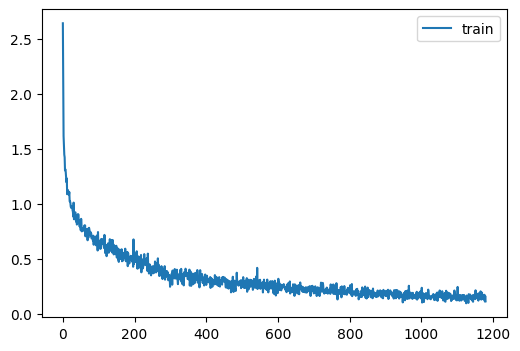

In [16]:
learn.fit(epochs)

In [ ]:
model_summary['case_07'] = {
    'act_func': 'GRLU(def)',
    'model': 'model3',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.0, 0.0',
    'seed': 42,
    '5_ep_loss': 0.352,
    '5_ep_acc': 88.7,
    '20_ep_loss': 0.169,
    '20_ep_acc': 94.3,
}

In [18]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [19]:
torch.save(learn.model, mdl_path/'case_7.pkl')

### Case8

In [63]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=[0.0, 0.0, 0.0]):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop[0])]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]    
    layers += [nn.Dropout2d(drop[1]), nn.Flatten(), nn.Linear(nfs[-1], 100), nn.Dropout1d(drop[1]), 
               nn.Linear(100, 10, bias=False), 
                            nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [64]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model4(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.0, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.644,1.208,0,True
0.756,0.779,0,False
0.798,0.761,1,True
0.826,0.560,1,False
0.837,0.594,2,True
0.830,0.527,2,False
0.844,0.520,3,True
0.828,0.536,3,False
0.867,0.408,4,True
0.865,0.387,4,False


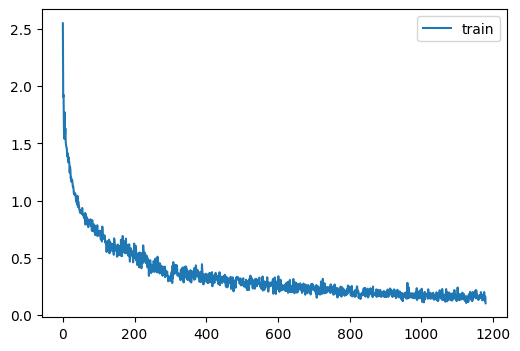

In [65]:
learn.fit(epochs)

In [68]:
model_summary['case_08'] = {
    'act_func': 'GRLU(def)',
    'model': 'model4',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.0, 0.0',
    'seed': 42,
    '5_ep_loss': 0.387,
    '5_ep_acc': 86.5,
    '20_ep_loss': 0.172,
    '20_ep_acc': 94.0,
}

### Case 9 

In [70]:
def get_model5(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=[0.0, 0.0, 0.0]):
    layers = [ResBlock2(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop[0])]
    layers += [ResBlock2(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]    
    layers += [nn.Dropout2d(drop[1]), nn.Flatten(), nn.Linear(nfs[-1], 100), nn.Dropout1d(drop[1]), 
               nn.Linear(100, 10, bias=False), 
                            nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [71]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model5(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.05, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.647,1.158,0,True
0.760,0.761,0,False
0.771,0.794,1,True
0.828,0.567,1,False
0.800,0.661,2,True
0.785,0.679,2,False
0.811,0.585,3,True
0.847,0.465,3,False
0.827,0.514,4,True
0.881,0.367,4,False


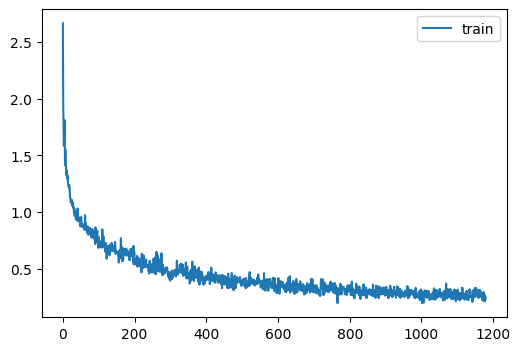

In [72]:
learn.fit(epochs)

In [73]:
model_summary['case_09'] = {
    'act_func': 'GRLU(def)',
    'model': 'model5',
    'lr_max': 1.E-2,
    'drops': '0.1, 0.05, 0.0',
    'seed': 42,
    '5_ep_loss': 0.367,
    '5_ep_acc': 88.1,
    '20_ep_loss': 0.176,
    '20_ep_acc': 94.0,
}

## Augmentations 

### Case 10

In [101]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     #transforms.ColorJitter(brightness=0.1, contrast=0.05),
                     transforms.RandomAffine(degrees=10, shear=10),
                     RandCopy())
augcb_enh = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [102]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb_enh]
model = get_model(act_gr, norm=nn.BatchNorm2d, drop=[0.2, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.637,1.218,0,True
0.751,0.787,0,False
0.777,0.806,1,True
0.814,0.576,1,False
0.815,0.646,2,True
0.810,0.568,2,False
0.822,0.571,3,True
0.851,0.446,3,False
0.852,0.446,4,True
0.873,0.370,4,False


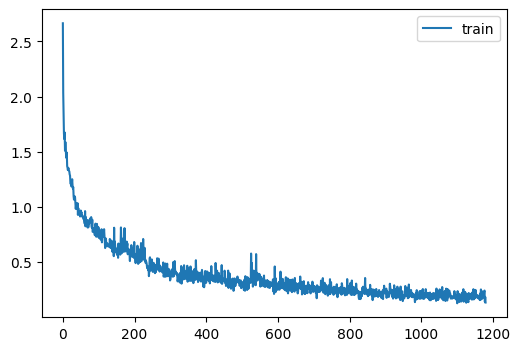

In [103]:
learn.fit(epochs)

15, 10 - 0.844, 0.459
10, 10 - 0.873, 0.370
10, 12.5 - 0.851, 0.430
10, 7.5 - 0.876, 0.374
10, 5.0 - 0.853, 0.428
5, 10 - 0.858, 0.409
8, 10 - 0.868, 0.401


In [104]:
model_summary['case_10'] = {
    'act_func': 'GRLU(def)',
    'model': 'model',
    'lr_max': 1.E-2,
    'drops': '0.2, 0.0',
    'seed': 42,
    '5_ep_loss': 0.370,
    '5_ep_acc': 83.7,
    '20_ep_loss': 0.197,
    '20_ep_acc': 93.0,
}

### Case 11 

In [106]:
epochs = 20
set_seed(42)
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model3(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.0, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.723,0.995,0,True
0.799,0.633,0,False
0.828,0.636,1,True
0.823,0.548,1,False
0.844,0.522,2,True
0.864,0.419,2,False
0.859,0.433,3,True
0.881,0.369,3,False
0.876,0.367,4,True
0.889,0.349,4,False


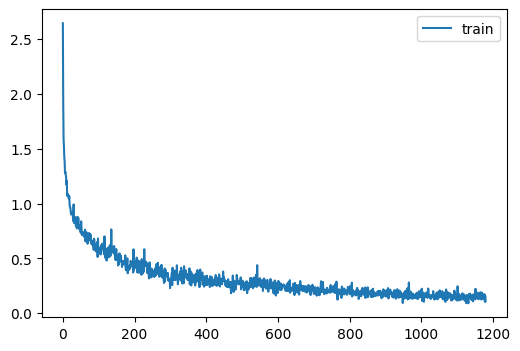

In [107]:
learn.fit(epochs)

### Leader Board

In [105]:
pd.DataFrame.from_dict(model_summary)

,case_01,case_02,case_03,case_04,case_05,case_06,case_07,case_08,case_09,case_10
act_func,GRLU(def),Mish(def),GRLU(def),GRLU(def),GRLU(def),GRLU(def),GRLU(def),GRLU(def),GRLU(def),GRLU(def)
model,base,base,base,base,base,model2,model3,model4,model5,model
lr_max,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
drops,"0.1, 0.1","0.1, 0.1","0.0, 0.1","0.1, 0.0","0.2, 0.0","0.1, 0.1, 0.0","0.1, 0.0, 0.0","0.1, 0.0, 0.0","0.1, 0.0, 0.0","0.2, 0.0"
seed,42,42,42,42,42,42,42,42,42,42
5_ep_loss,0.429,0.764,0.543,0.617,0.439,0.361,0.352,0.387,0.367,0.37
5_ep_acc,84.5,81.9,82.2,78.9,84.7,87.8,88.7,86.5,88.1,83.7
20_ep_loss,0.174,0.213,0.18,0.167,0.173,0.173,0.169,0.172,0.176,0.197
20_ep_acc,93.9,92.4,93.8,0.942,0.938,0.939,94.3,94.0,94.0,93.0


## Look at where the model fails 

In [49]:
epochs = 20
set_seed(42)
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model3(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.0, 0.0]).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs_get_preds+[augcb], opt_func=optim.AdamW)

In [50]:
mdl_path = Path('models')
learn.model = torch.load(os.path.join(mdl_path, 'case_7.pkl'))

In [56]:
learn.fit(n_epochs=1, train=False, valid=True, cbs=cbs_get_preds+[augcb, TopLossesCallback()])

In [24]:
len(learn.dls.valid.top_losses)

10000

In [25]:
learn.dls.valid.top_losses[0:20]

tensor([2914, 1111, 3800, 1953, 6926, 8919, 4405,  147, 2985, 3625, 5381, 8688, 5806,  732, 7948, 3008, 3132, 3531,  787,  979],
       device='cuda:0')

### Simple example 

In [15]:
model = get_model3(act_gr, norm=nn.BatchNorm2d, drop=[0.1, 0.0, 0.0]).apply(iw)

In [16]:
epochs=1
set_seed(42)
lr = 1e-2
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs_get_preds + [augcb])

In [17]:
learn.fit(1)

In [19]:
learn.fit(n_epochs=1, train=False, valid=True, cbs=cbs_get_preds+[augcb])

In [ ]:
learn.